In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
import torchvision
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
#from torchsummary import summary
import numpy as np

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class NoisyFashionMNIST(Dataset):
    def __init__(self, root, train = True):
        """
        Creates a noisy dataset from the FashionMNIST
        """

        transform = transforms.ToTensor()
        self.noise = AddGaussianNoise(0., 0.1)
        self.dataset = datasets.FashionMNIST(root, train = train, download=True, transform = transform)

    def __len__(self):
            return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx][0]
        return self.noise(img), img


Using device: cpu


In [2]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset_1 = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset_1 = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [4]:
# Define Train/Test Functions
def train_epoch(model: torch.nn.Module, train_loader: DataLoader, f_loss: torch.nn.modules.loss, optimizer: torch.optim.Optimizer, minimize: bool):
    epoch_loss = []

    for _, (batch_img, batch_target) in enumerate(train_loader):
        output = model(batch_img)

        if minimize:
            loss = f_loss(output, batch_target)
        else:
            loss = -f_loss(output, batch_target)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        with torch.no_grad():
            epoch_loss += [loss.item()]

    return np.array(epoch_loss).mean()

@torch.no_grad()
def test(model: torch.nn.Module, test_loader: DataLoader):
    model.eval()
    true_labels = []
    pred_labels = []
    for _, (batch_img, batch_targets) in enumerate(test_loader):
        y = model.predict(batch_img)

        pred_labels.append(y.numpy())
        true_labels.append(batch_targets.numpy())

    return np.array(pred_labels).flatten(), np.array(true_labels).flatten()

@torch.no_grad()
def eval(model: torch.nn.Module, eval_loader: DataLoader, f_loss: torch.nn.modules.loss, minimize: bool):
    model.eval()
    correct_predictions = 0
    test_loss = []

    for _, (batch_img, batch_targets) in enumerate(eval_loader):
        y = model.forward(batch_img)

        if minimize:
            loss = f_loss(y, batch_targets)
        else:
            loss = -f_loss(y, batch_targets)

        test_loss += [loss.item()]

        predictions = torch.argmax(y, dim=1)
        num_correct_predictions = torch.sum(predictions == batch_targets).item()
        correct_predictions += num_correct_predictions

    test_acc = correct_predictions / len(eval_loader.dataset)
    test_loss = np.array(test_loss).mean()

    return test_loss, test_acc, correct_predictions, len(eval_loader.dataset)

def train(model: torch.nn.Module, loaders: dict[DataLoader], f_loss: torch.nn.modules.loss, optimizer: torch.optim.Optimizer, num_epochs=20, minimize: bool=True):
    model.train()

    train_loss = []
    test_loss = []
    test_acc = []

    for epoch in range(num_epochs):
        epoch_train_loss = train_epoch(model, loaders["train"], f_loss, optimizer, minimize)

        with torch.no_grad():
            epoch_test_loss, epoch_test_acc, corr_pred, num_pred = eval(model, loaders["test"], f_loss, minimize)

            print(f"epoch: {epoch} train_loss: {round(epoch_train_loss, 2)} "
                  f"test_loss: {round(epoch_test_loss, 2)} test_acc: {round(epoch_test_acc, 2)} ({corr_pred}/{num_pred})")

            train_loss.append(epoch_train_loss)
            test_loss.append(epoch_test_loss)
            test_acc.append(epoch_test_acc)

    return train_loss, test_loss, test_acc



In [5]:
def plot_summery(
        train_losses,
        test_losses,
        test_accs,
        names,
        with_acc: bool=True
):
    if with_acc:
        num_plots = 3
    else:
        num_plots = 2
    
    plt.figure(figsize=(16,4))
    plt.subplot(1, num_plots, 1)
    for loss, name in zip(train_losses, names):
        plt.plot(loss, label=name)
    plt.title("Train Loss")
    #plt.show()

    plt.subplot(1, num_plots, 2)
    for loss, name in zip(test_losses, names):
        plt.plot(loss, label=name)
    plt.title("Test Loss")
    #plt.show()

    if with_acc:
        plt.subplot(1, num_plots, 3)
        for acc, name in zip(test_accs, names):
            plt.plot(acc, label=name)
        plt.title("Test Accuracy")
    plt.legend()
    plt.savefig("resources/res_denoise.png")

# Denoising
## Dataset

In [6]:
train_dataset = NoisyFashionMNIST("./data", True)
test_dataset = NoisyFashionMNIST("./data", False)

In [7]:
loaders = {
    'train' : DataLoader(train_dataset,
                        batch_size=32,
                        shuffle=True,
                        #num_workers=1
                        ),

    'test'  : DataLoader(test_dataset,
                        batch_size=32,
                        shuffle=False,
                        #num_workers=1
                        ),
}

## Model (Base Model)

In [8]:
#Image Denoising
class DenoiseNet(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.img_size = (28, 28)

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5), # NxCxHxW   Nx10x24x24
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx10x12x12

            torch.nn.Conv2d(10, 15, kernel_size=5), # NxCxHxW   Nx15x8x8
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx15x4x4
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(15, 8, kernel_size=3, stride=3), # NxCxHxW Nx8x12x12
            torch.nn.ReLU(),

            torch.nn.ConvTranspose2d(8, 1, kernel_size=6, stride=2), # NxCxHxW Nx1x28x28
            torch.nn.Sigmoid()
        )

        self.params_to_optimize = [
            {'params': self.encoder.parameters()},
            {'params': self.decoder.parameters()}
        ]

    def forward(self, x):
        hidden = self.encoder(x)
        y = self.decoder(hidden)
        return y

    @ torch.no_grad()
    def predict(self, x):
        return self.forward(x)

In [9]:
model_denoise = DenoiseNet()
optimizer = torch.optim.Adam(model_denoise.params_to_optimize, lr=0.0003)
f_loss = torch.nn.BCELoss()

## Training

In [10]:
train_loss_denoise, test_loss_denoise, _ = train(model_denoise, loaders, f_loss, optimizer, num_epochs=20)
pred_labels_denoise, true_labels_denoise = test(model_denoise, loaders["test"])

epoch: 0 train_loss: 0.4 test_loss: 0.35 test_acc: 12529.94 (125299376/10000)
epoch: 1 train_loss: 0.34 test_loss: 0.33 test_acc: 12529.94 (125299376/10000)
epoch: 2 train_loss: 0.33 test_loss: 0.32 test_acc: 12529.94 (125299376/10000)
epoch: 3 train_loss: 0.32 test_loss: 0.32 test_acc: 12529.94 (125299376/10000)
epoch: 4 train_loss: 0.32 test_loss: 0.32 test_acc: 12529.94 (125299376/10000)
epoch: 5 train_loss: 0.32 test_loss: 0.32 test_acc: 12529.94 (125299376/10000)
epoch: 6 train_loss: 0.32 test_loss: 0.32 test_acc: 12529.94 (125299376/10000)
epoch: 7 train_loss: 0.31 test_loss: 0.32 test_acc: 12529.94 (125299376/10000)
epoch: 8 train_loss: 0.31 test_loss: 0.32 test_acc: 12529.94 (125299376/10000)
epoch: 9 train_loss: 0.31 test_loss: 0.31 test_acc: 12529.94 (125299376/10000)
epoch: 10 train_loss: 0.31 test_loss: 0.31 test_acc: 12529.94 (125299376/10000)
epoch: 11 train_loss: 0.31 test_loss: 0.31 test_acc: 12529.94 (125299376/10000)
epoch: 12 train_loss: 0.31 test_loss: 0.31 test_acc

/tmp/ipykernel_143623/931925779.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pred_labels).flatten(), np.array(true_labels).flatten()


## Evaluation

In [11]:
output1 = []

for i, (images, labels) in enumerate(loaders["test"]):
    y = model_denoise.predict(images)
    output1.append(y)

results_denoise = torch.concatenate(output1, axis=0)
results_denoise.shape

torch.Size([10000, 1, 28, 28])

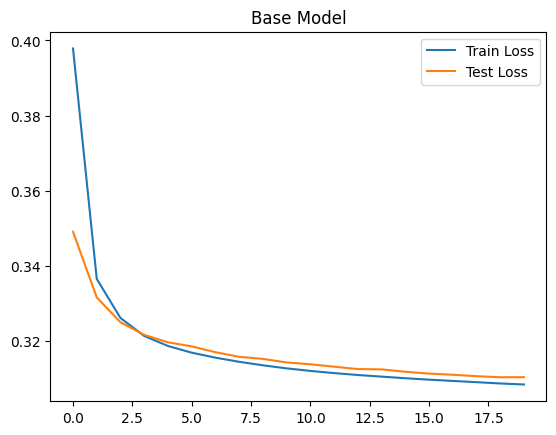

In [12]:
plt.plot(train_loss_denoise, label="Train Loss")
plt.plot(test_loss_denoise, label="Test Loss")
plt.title("Base Model")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


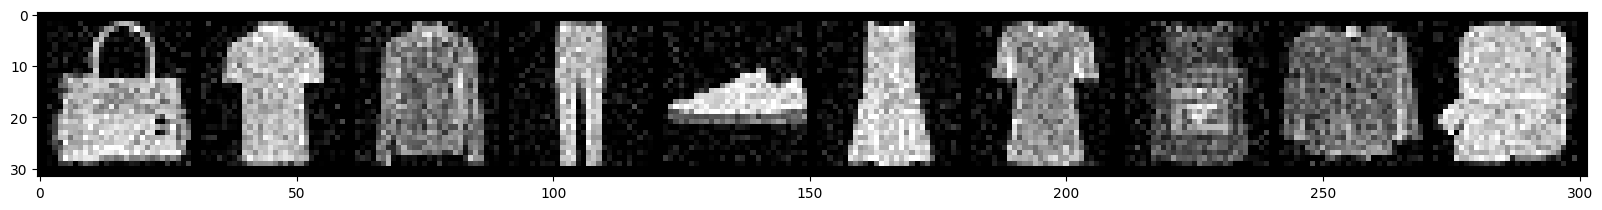

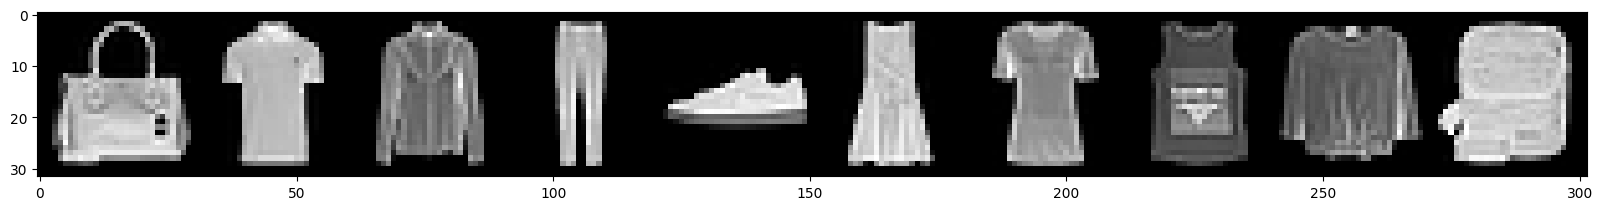

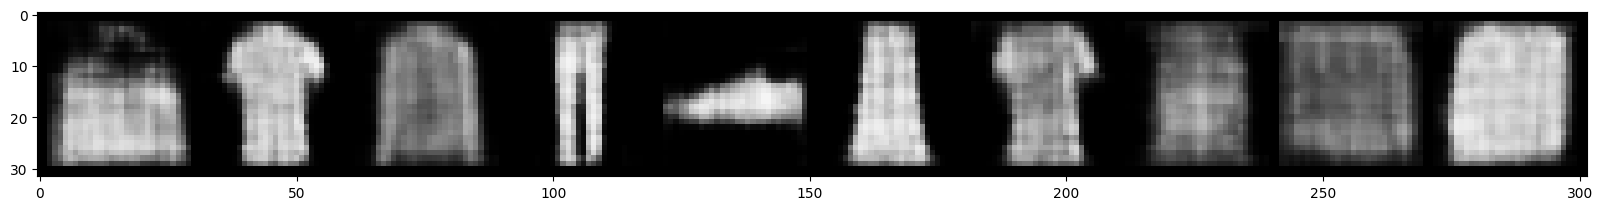

In [35]:
rant = [8701, 4765, 7678, 5323, 7923, 8339, 3260, 6679, 5796, 6966]
rant_idx = np.asarray(rant)
noisy, og = list(zip(*[test_dataset.__getitem__(i) for i in rant_idx]))
noisy = torch.stack(list(noisy), dim=0)
og = torch.stack(list(og), dim=0)

pred_denoise = [results_denoise[i] for i in rant_idx]

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(noisy, nrow=10))
plt.show()

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(og, nrow=10))
plt.show()

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(pred_denoise, nrow=10))
plt.savefig("resources/res_base.png")
plt.show()


## Denoising (Residual)

In [14]:
#Exercise 4 task 3
# Evaluate the effect of Residual Connection

## Resiudal effect
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
      super().__init__()
      self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
      self.batch1 = torch.nn.BatchNorm2d(out_channels)
      self.relu1 = torch.nn.ReLU()
      self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
      self.batch2 = torch.nn.BatchNorm2d(out_channels)
      self.relu2 = torch.nn.ReLU()
      if in_channels != out_channels:
          self.matching_conv = torch.nn.Conv2d(in_channels, out_channels, 1)  # 1x1 conv
      else:
          self.matching_conv = None


    def forward(self,x):
      residual = x
      if self.matching_conv is not None:
          residual = self.matching_conv(residual)  # Change the number of channels in residual to match out
      out = self.conv1(x)
      out = self.batch1(out)
      out = self.relu1(out)
      out = self.conv2(out)
      out = self.batch2(out)
      out += residual
      out = self.relu2(out)
      return out

class ResDeNet(torch.nn.Module):
  def __init__(self):
        super().__init__()
        self.img_size = (28, 28)
        self.lr = 1e-3

        self.criterion = torch.nn.BCELoss()


        self.encoder = torch.nn.Sequential(
            ResidualBlock(1,10),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx10x12x12

            ResidualBlock(10,15),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx15x4x4
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(15, 8, kernel_size=4, stride=2, padding=1),  # NxCxHxW Nx8x14x14
            torch.nn.ReLU(),
            ResidualBlock(8,1),  # The ResidualBlock should preserve the spatial dimensions
            torch.nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1),  # The spatial dimensions should now be doubled
            torch.nn.Sigmoid()
)

        self.params_to_optimize = [
            {'params': self.encoder.parameters()},
            {'params': self.decoder.parameters()}
]

        self.optimizer = torch.optim.Adam(self.params_to_optimize)

  def forward(self, x):
      hidden = self.encoder(x)
      y = self.decoder(hidden)
      return y

  @ torch.no_grad()
  def predict(self, x):
      self.encoder.eval()
      self.decoder.eval()

      return self.forward(x)

In [15]:
model_residual = ResDeNet()
optimizer = torch.optim.Adam(model_residual.params_to_optimize, lr=0.0003)
f_loss = torch.nn.BCELoss()

residual_train_loss, residual_test_loss, _ = train(model_residual, loaders, f_loss, optimizer, num_epochs=20)
residual_pred_labels, residual_true_labels = test(model_residual, loaders["test"])

epoch: 0 train_loss: 0.33 test_loss: 0.29 test_acc: 12529.94 (125299376/10000)
epoch: 1 train_loss: 0.28 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 2 train_loss: 0.28 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 3 train_loss: 0.27 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 4 train_loss: 0.27 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 5 train_loss: 0.27 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 6 train_loss: 0.27 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 7 train_loss: 0.27 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 8 train_loss: 0.27 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 9 train_loss: 0.27 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 10 train_loss: 0.27 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 11 train_loss: 0.27 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 12 train_loss: 0.27 test_loss: 0.28 test_ac

/tmp/ipykernel_143623/931925779.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pred_labels).flatten(), np.array(true_labels).flatten()


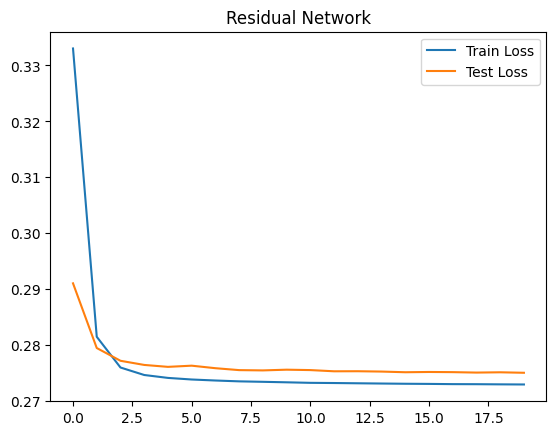

In [16]:
plt.plot(residual_train_loss, label="Train Loss")
plt.plot(residual_test_loss, label="Test Loss")
plt.title("Residual Network")
plt.legend()
plt.show()

In [17]:
output_resiudal = []

for i, (images, labels) in enumerate(loaders["test"]):
    y = model_residual.predict(images)
    output_resiudal.append(y)

result_resiudal = torch.concatenate(output_resiudal, axis=0)
result_resiudal.shape

torch.Size([10000, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


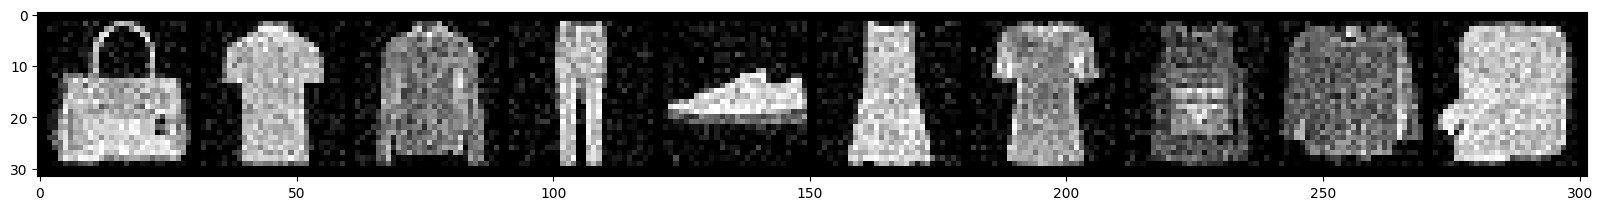

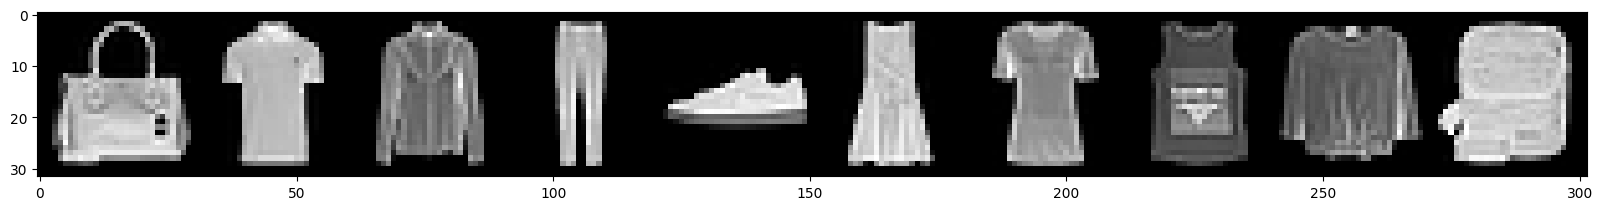

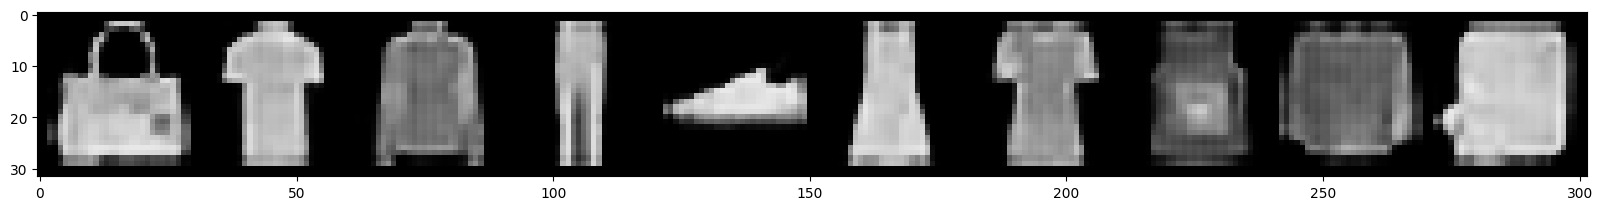

In [36]:
rant = [8701, 4765, 7678, 5323, 7923, 8339, 3260, 6679, 5796, 6966]
rant_idx = np.asarray(rant)
noisy, og = list(zip(*[test_dataset.__getitem__(i) for i in rant_idx]))
noisy = torch.stack(list(noisy), dim=0)
og = torch.stack(list(og), dim=0)

pred_resiudal = [result_resiudal[i] for i in rant_idx]

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(noisy, nrow=10))
plt.show()

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(og, nrow=10))
plt.show()

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(pred_resiudal, nrow=10))
plt.savefig("resources/res_residiual.png")
plt.show()


## Denoising (deeper model)

In [19]:
#Task3: Model Selection
#Evaluate the effect of the depth(number of layers)/width (number of channels or number of neurons) of the network

class DepthDenoiseNet(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.img_size = (28, 28)

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=5), # NxCxHxW   Nx10x24x24
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx10x12x12

            torch.nn.Conv2d(32,64, kernel_size=5), # NxCxHxW   Nx20x8x8
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx20x4x4

            torch.nn.Conv2d(64, 128, kernel_size=3), # NxCxHxW   Nx30x2x2
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx30x1x1
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), # NxCxHxW Nx20x2x2
            torch.nn.ReLU(),

            torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=3), # NxCxHxW Nx10x6x6
            torch.nn.ReLU(),

            torch.nn.ConvTranspose2d(32, 1, kernel_size=5, stride=5,padding = 1), # NxCxHxW Nx1x28x28
            torch.nn.Sigmoid()
        )

        self.params_to_optimize = [
            {'params': self.encoder.parameters()},
            {'params': self.decoder.parameters()}
        ]

    def forward(self, x):
        hidden = self.encoder(x)
        y = self.decoder(hidden)
        return y

    @ torch.no_grad()
    def predict(self, x):
        return self.forward(x)

In [20]:
model_depth = DepthDenoiseNet()

optimizer = torch.optim.Adam(model_depth.params_to_optimize, lr=0.0003)
f_loss = torch.nn.BCELoss()

In [21]:
train_depth_loss, test_depth_loss, _ = train(model_depth, loaders, f_loss, optimizer, num_epochs=20)
pred_depth_labels, true_depth_labels = test(model_depth, loaders["test"])

epoch: 0 train_loss: 0.36 test_loss: 0.31 test_acc: 12529.94 (125299376/10000)
epoch: 1 train_loss: 0.3 test_loss: 0.3 test_acc: 12529.94 (125299376/10000)
epoch: 2 train_loss: 0.29 test_loss: 0.29 test_acc: 12529.94 (125299376/10000)
epoch: 3 train_loss: 0.29 test_loss: 0.29 test_acc: 12529.94 (125299376/10000)
epoch: 4 train_loss: 0.29 test_loss: 0.29 test_acc: 12529.94 (125299376/10000)
epoch: 5 train_loss: 0.28 test_loss: 0.29 test_acc: 12529.94 (125299376/10000)
epoch: 6 train_loss: 0.28 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 7 train_loss: 0.28 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 8 train_loss: 0.28 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 9 train_loss: 0.28 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 10 train_loss: 0.28 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 11 train_loss: 0.28 test_loss: 0.28 test_acc: 12529.94 (125299376/10000)
epoch: 12 train_loss: 0.28 test_loss: 0.28 test_acc:

/tmp/ipykernel_143623/931925779.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pred_labels).flatten(), np.array(true_labels).flatten()


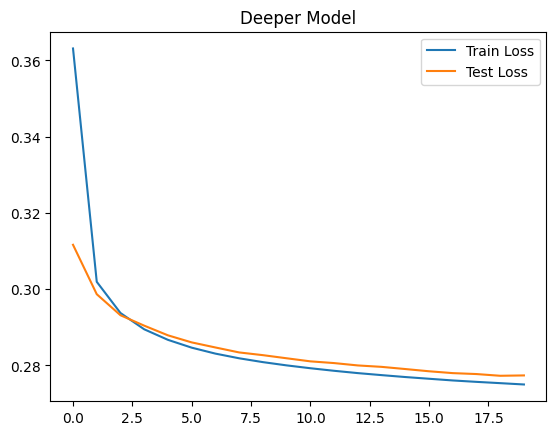

In [22]:
plt.plot(train_depth_loss, label="Train Loss")
plt.plot(test_depth_loss, label="Test Loss")
plt.title("Deeper Model")
plt.legend()
plt.show()

In [23]:
output_depth = []

for i, (images, labels) in enumerate(loaders["test"]):
    y = model_depth.predict(images)
    output_depth.append(y)

result_depth = torch.concatenate(output_depth, axis=0)
result_depth.shape

torch.Size([10000, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


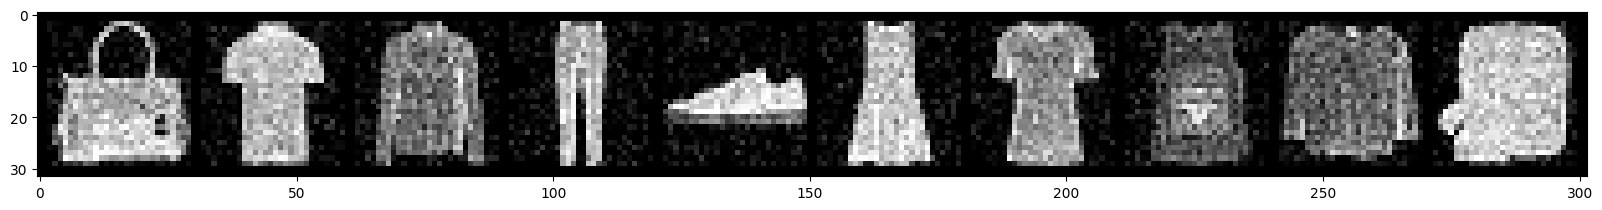

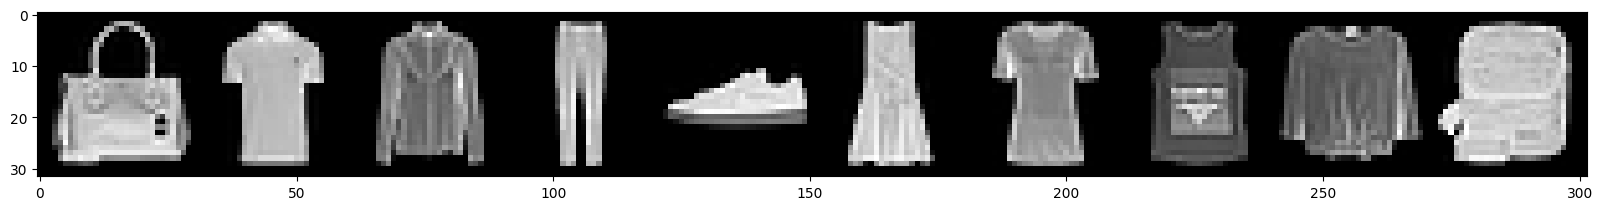

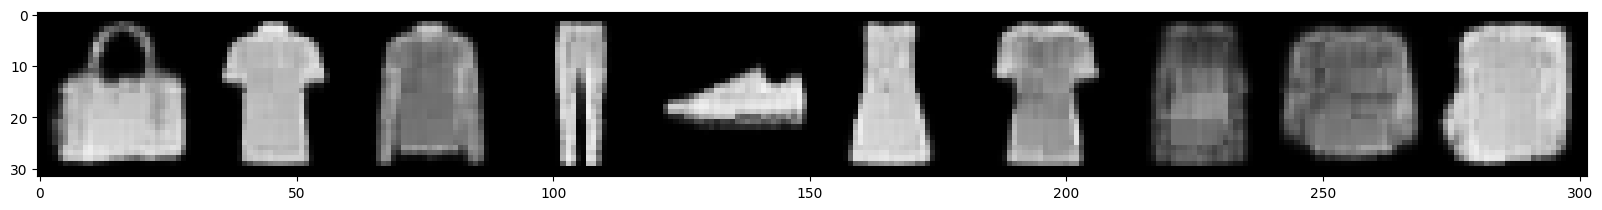

In [37]:
rant_depth = [8701, 4765, 7678, 5323, 7923, 8339, 3260, 6679, 5796, 6966]
rant_depth_idx = np.asarray(rant_depth)
noisy, og = list(zip(*[test_dataset.__getitem__(i) for i in rant_depth_idx]))
noisy = torch.stack(list(noisy), dim=0)
og = torch.stack(list(og), dim=0)

pred_depth = [result_depth[i] for i in rant_depth_idx]

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(noisy, nrow=10))
plt.show()

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(og, nrow=10))
plt.show()

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(pred_depth, nrow=10))
plt.savefig("resources/res_deep.png")
plt.show()


## Denoising (BatchNorm)

In [25]:
#Task 3:Model Selection
#Evaluate the effect of Batch normalization

class BatchDenoiseNet(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.img_size = (28, 28)

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5),# NxCxHxW   Nx10x24x24
            torch.nn.BatchNorm2d(10),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx10x12x12

            torch.nn.Conv2d(10, 15, kernel_size=5), # NxCxHxW   Nx15x8x8
            torch.nn.BatchNorm2d(15),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2), # NxCxHxW   Nx15x4x4
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(15, 8, kernel_size=3, stride=3), # NxCxHxW Nx8x12x12
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),

            torch.nn.ConvTranspose2d(8, 1, kernel_size=6, stride=2), # NxCxHxW Nx1x28x28
            torch.nn.BatchNorm2d(1),
            torch.nn.Sigmoid()
        )

        self.params_to_optimize = [
            {'params': self.encoder.parameters()},
            {'params': self.decoder.parameters()}
        ]

    def forward(self, x):
        hidden = self.encoder(x)
        y = self.decoder(hidden)
        return y

    @ torch.no_grad()
    def predict(self, x):
        return self.forward(x)

In [26]:
model_batch_norm = BatchDenoiseNet()

optimizer = torch.optim.Adam(model_batch_norm.params_to_optimize, lr=0.001)
f_loss = torch.nn.BCELoss()

In [27]:
train_batch_loss, test_batch_loss, _ = train(model_batch_norm, loaders, f_loss, optimizer, num_epochs=20)
pred_batch_labels, true_batch_labels = test(model_batch_norm, loaders["test"])

epoch: 0 train_loss: 0.39 test_loss: 0.33 test_acc: 12529.94 (125299376/10000)
epoch: 1 train_loss: 0.31 test_loss: 0.31 test_acc: 12529.94 (125299376/10000)
epoch: 2 train_loss: 0.31 test_loss: 0.31 test_acc: 12529.94 (125299376/10000)
epoch: 3 train_loss: 0.31 test_loss: 0.31 test_acc: 12529.94 (125299376/10000)
epoch: 4 train_loss: 0.3 test_loss: 0.31 test_acc: 12529.94 (125299376/10000)
epoch: 5 train_loss: 0.3 test_loss: 0.31 test_acc: 12529.94 (125299376/10000)
epoch: 6 train_loss: 0.3 test_loss: 0.3 test_acc: 12529.94 (125299376/10000)
epoch: 7 train_loss: 0.3 test_loss: 0.3 test_acc: 12529.94 (125299376/10000)
epoch: 8 train_loss: 0.3 test_loss: 0.3 test_acc: 12529.94 (125299376/10000)
epoch: 9 train_loss: 0.3 test_loss: 0.3 test_acc: 12529.94 (125299376/10000)
epoch: 10 train_loss: 0.3 test_loss: 0.3 test_acc: 12529.94 (125299376/10000)
epoch: 11 train_loss: 0.3 test_loss: 0.3 test_acc: 12529.94 (125299376/10000)
epoch: 12 train_loss: 0.3 test_loss: 0.3 test_acc: 12529.94 (125

/tmp/ipykernel_143623/931925779.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pred_labels).flatten(), np.array(true_labels).flatten()


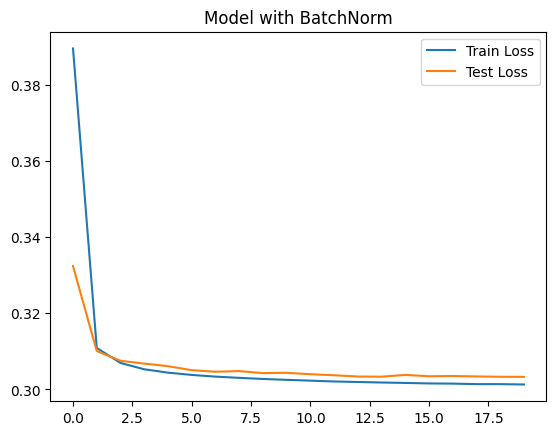

In [28]:
plt.plot(train_batch_loss, label="Train Loss")
plt.plot(test_batch_loss, label="Test Loss")
plt.title("Model with BatchNorm")
plt.legend()
plt.show()

In [29]:
output_batch = []

for i, (images, labels) in enumerate(loaders["test"]):
    y = model_batch_norm.predict(images)
    output_batch.append(y)

result_batch = torch.concatenate(output_batch, axis=0)
result_batch.shape

torch.Size([10000, 1, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


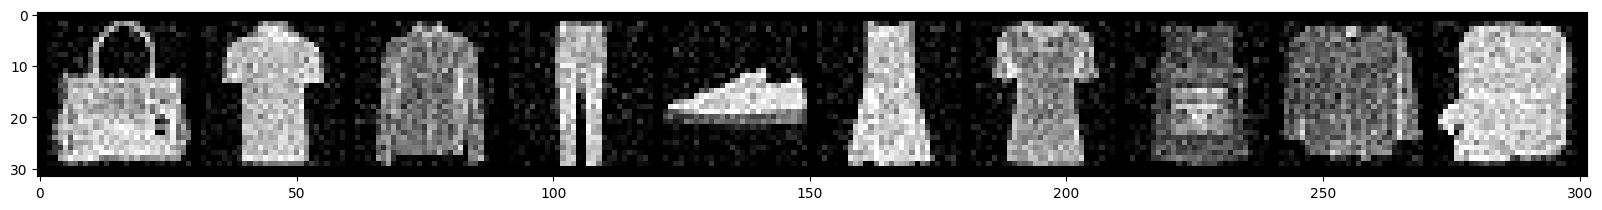

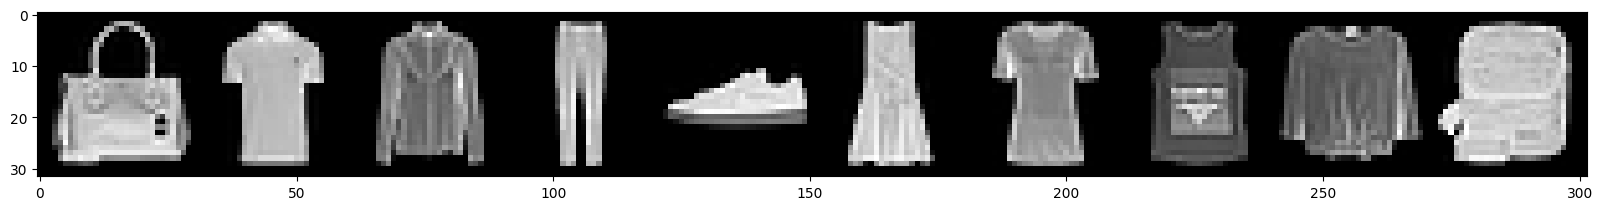

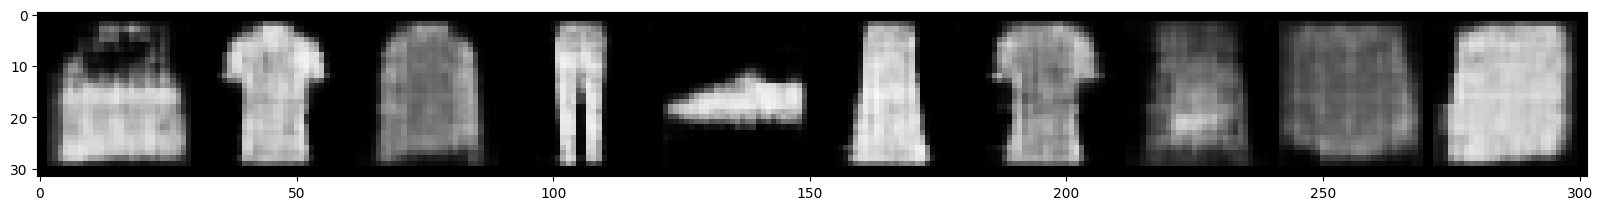

In [39]:
rant_batch = [8701, 4765, 7678, 5323, 7923, 8339, 3260, 6679, 5796, 6966]
rant_batch_idx = np.asarray(rant_batch)
noisy, og = list(zip(*[test_dataset.__getitem__(i) for i in rant_batch_idx]))
noisy = torch.stack(list(noisy), dim=0)
og = torch.stack(list(og), dim=0)

pred_batch = [result_batch[i] for i in rant_batch_idx]

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(noisy, nrow=10))
plt.savefig("resources/noisy.png")
plt.show()


plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(og, nrow=10))
plt.savefig("resources/origial.png")
plt.show()


plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(pred_batch, nrow=10))
plt.savefig("resources/res_batchnorm.png")
plt.show()


# Evaluation Denoising

In [31]:
denoise_train_losses = [train_loss_denoise, train_batch_loss, train_depth_loss, residual_train_loss]
denoise_test_losses = [test_loss_denoise, test_batch_loss, test_depth_loss, residual_test_loss]

models = ["Base Model", "Model with BachNorm", "Deeper Model", "Model with Residual Connections"]

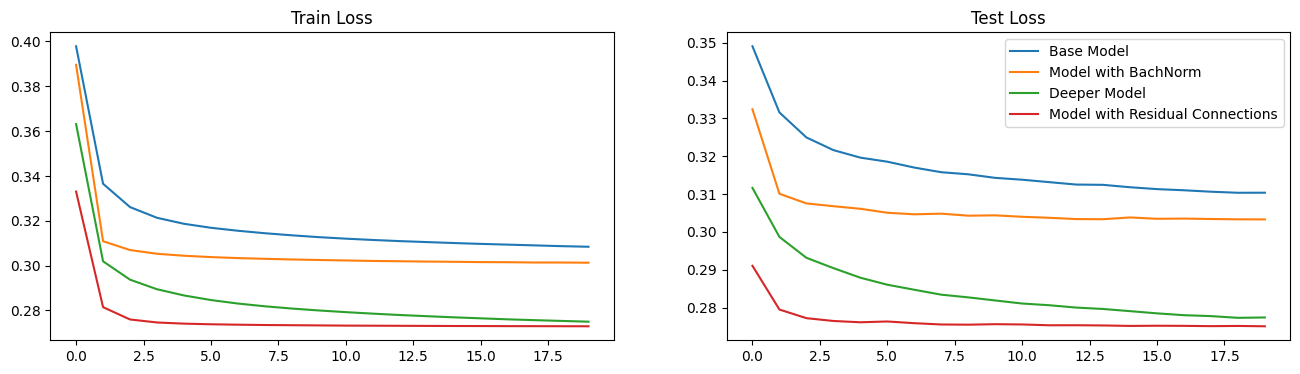

In [32]:
plot_summery(denoise_train_losses, denoise_test_losses, [], models, with_acc=False)